In [ ]:
from regraph import NXGraph, Neo4jGraph, Rule, plot_rule

graph = Neo4jGraph(
    uri="bolt://localhost:7687",
    user="",
    password="",
    node_label="Vertex",
    edge_label="LEG_TO",)

pattern = NXGraph()

length = 3

pattern.add_nodes_from([f"n{i}" for i in range(1, length)])
pattern.add_edges_from([
    (f"n{i}", f"n{i + 1}") for i in range(1, length - 1)
])
for i in range(1, length):
    pattern.add_node_attrs(f"n{i}", {"t": 1})

instances = graph.find_matching(pattern)
print("Instances of pattern in graph:", len(instances))

Query:  MATCH (n1:Vertex), (n2:Vertex), (n1)-[n1_to_n2:LEG_TO]->(n2)
WHERE id(n1) <> id(n2)
 AND 1 IN toSet([n1.t]) AND 1 IN toSet([n2.t])
RETURN n1, n2
Instances of pattern in graph: 9873


In [ ]:
"""
// Step 1: Match the pattern
MATCH (n)-[k]->(m)-[h]->(l)
WHERE 1 IN toSet([n.t]) AND 1 IN toSet([m.t]) AND 1 IN toSet([l.t])

// Step 2: Extract and compare attributes (sum phase)
CALL uuid_generator.get() YIELD uuid
WITH n, m, l, k, h,
     reduce(p_sum = 0, p IN [n.phase, m.phase, l.phase] | p_sum + p) AS combined_phase,
     n {.*, phase: null, id: uuid} AS attrs_n,
     [n, m, l] AS old_nodes

// Step 3: Create the new merged node
CREATE (new_node:Vertex)
SET new_node = attrs_n,
    combined.phase = combined_phase

// Step 4a: Redirect incoming edges (excluding internal)
WITH new_node, old_nodes
UNWIND old_nodes AS old
OPTIONAL MATCH (src)-[r_in]->(old)
WHERE NOT src IN old_nodes
WITH DISTINCT new_node, src, r_in, old_nodes
WHERE src IS NOT NULL
CREATE (src)-[new_in:LEG_TO]->(new_node)
SET new_in = r_in
DELETE r_in

// Step 4b: Redirect outgoing edges (excluding internal)
WITH new_node, old_nodes
UNWIND old_nodes AS old
OPTIONAL MATCH (old)-[r_out]->(dst)
WHERE NOT dst IN old_nodes
WITH DISTINCT new_node, dst, r_out, old_nodes
WHERE dst IS NOT NULL
CREATE (new_node)-[new_out:LEG_TO]->(dst)
SET new_out = r_out
DELETE r_out

// Step 5: Delete old nodes
WITH old_nodes
UNWIND old_nodes AS old
DETACH DELETE old
"""

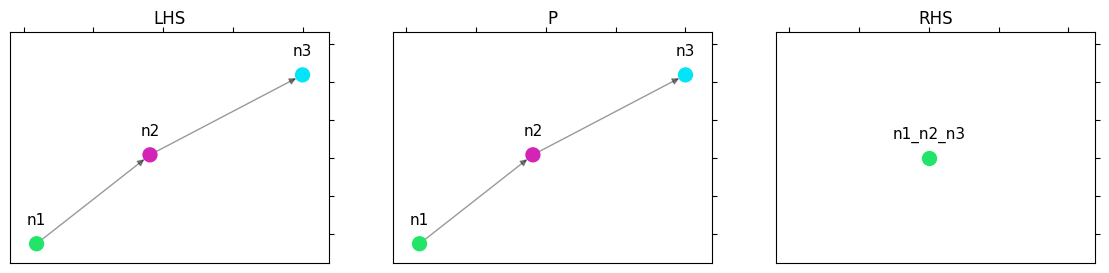

In [ ]:
rule = Rule.from_transform(pattern)
rule.inject_merge_nodes([f"n{i}" for i in range(1, length)])

plot_rule(rule)

In [ ]:
for instance in instances:
    rhs_graph = graph.rewrite(rule, instance)